<h1 align="center">SimpleITK Images and Resampling</h1>


**Summary:**    

1. Images occupy a region in physical space which is defined by:
  * Origin.
  * Size (number of pixels per dimension).
  * Spacing (unknown consistent units: nm, mm, m, km...).
  * Direction cosine matrix (axis directions in physical space).
  
  These attributes are the image's meta-data. Computing the physical coordinates from image indexes requires all four   components.

2. An image may contain a meta-data dictionary. This supplemental information often includes the image modality (e.g. CT), patient name, and information with respect to the image acquisition. 
3. Image initialization: user specified pixel type, user specified dimensionality (2,3), origin at zero, unit spacing in all dimensions and identity direction cosine matrix, intensities set to zero.
4. Data transfer to/from numpy: GetArrayFromImage (copy), GetArrayViewFromImage (immutable), GetImageFromArray (copy) + set the meta-data yourself. 
5. A common issue with resampling resulting in an all black image is due to (a) incorrect specification of the 
desired output image's spatial domain (its meta-data); or (b) the use of the inverse of the transformation mapping from the output spatial domain to the resampled image.

## Images are Physical Objects

<img src="figures/ImageOriginAndSpacing.png" style="width:700px"/><br><br>

### Pixel Types

The pixel type is represented as an enumerated type. The following is a table of the enumerations and corresponding pixel types.

<table>
  <tr><th style="text-align:left">Enumeration</th><th style="text-align:left">Pixel Type</th></tr>
  <tr><td style="text-align:left">sitkUInt8</td><td style="text-align:left">Unsigned 8 bit integer</td></tr>
  <tr><td style="text-align:left">sitkInt8</td><td style="text-align:left">Signed 8 bit integer</td></tr>
  <tr><td style="text-align:left">sitkUInt16</td><td style="text-align:left">Unsigned 16 bit integer</td></tr>
  <tr><td style="text-align:left">sitkInt16</td><td style="text-align:left">Signed 16 bit integer</td></tr>
  <tr><td style="text-align:left">sitkUInt32</td><td style="text-align:left">Unsigned 32 bit integer</td></tr>
  <tr><td style="text-align:left">sitkInt32</td><td style="text-align:left">Signed 32 bit integer</td></tr>
  <tr><td style="text-align:left">sitkUInt64</td><td style="text-align:left">Unsigned 64 bit integer</td></tr>
  <tr><td style="text-align:left">sitkInt64</td><td style="text-align:left">Signed 64 bit integer</td></tr>
  <tr><td style="text-align:left">sitkFloat32</td><td style="text-align:left">32 bit float</td></tr>
  <tr><td style="text-align:left">sitkFloat64</td><td style="text-align:left">64 bit float</td></tr>
  <tr><td style="text-align:left">sitkComplexFloat32</td><td style="text-align:left">complex number of 32 bit float</td></tr>
  <tr><td style="text-align:left">sitkComplexFloat64</td><td style="text-align:left">complex number of 64 bit float</td></tr>
  <tr><td style="text-align:left">sitkVectorUInt8</td><td style="text-align:left">Multi-component of unsigned 8 bit integer</td></tr>
  <tr><td style="text-align:left">sitkVectorInt8</td><td style="text-align:left">Multi-component of signed 8 bit integer</td></tr>
  <tr><td style="text-align:left">sitkVectorUInt16</td><td style="text-align:left">Multi-component of unsigned 16 bit integer</td></tr>
  <tr><td style="text-align:left">sitkVectorInt16</td><td style="text-align:left">Multi-component of signed 16 bit integer</td></tr>
  <tr><td style="text-align:left">sitkVectorUInt32</td><td style="text-align:left">Multi-component of unsigned 32 bit integer</td></tr>
  <tr><td style="text-align:left">sitkVectorInt32</td><td style="text-align:left">Multi-component of signed 32 bit integer</td></tr>
  <tr><td style="text-align:left">sitkVectorUInt64</td><td style="text-align:left">Multi-component of unsigned 64 bit integer</td></tr>
  <tr><td style="text-align:left">sitkVectorInt64</td><td style="text-align:left">Multi-component of signed 64 bit integer</td></tr>
  <tr><td style="text-align:left">sitkVectorFloat32</td><td style="text-align:left">Multi-component of 32 bit float</td></tr>
  <tr><td style="text-align:left">sitkVectorFloat64</td><td style="text-align:left">Multi-component of 64 bit float</td></tr>
  <tr><td style="text-align:left">sitkLabelUInt8</td><td style="text-align:left">RLE label of unsigned 8 bit integers</td></tr>
  <tr><td style="text-align:left">sitkLabelUInt16</td><td style="text-align:left">RLE label of unsigned 16 bit integers</td></tr>
  <tr><td style="text-align:left">sitkLabelUInt32</td><td style="text-align:left">RLE label of unsigned 32 bit integers</td></tr>
  <tr><td style="text-align:left">sitkLabelUInt64</td><td style="text-align:left">RLE label of unsigned 64 bit integers</td></tr>
</table>

There is also `sitkUnknown`, which is used for undefined or erroneous pixel ID's.

Some filters only work with images with a specific pixel type. The primary example is the registration framework which works with sitkFloat32 or sitkFloat64. To address this issue you can either specify the appropriate pixel type when reading or creating the image, or use the <a href="https://simpleitk.org/doxygen/latest/html/namespaceitk_1_1simple.html#af8c9d7cc96a299a05890e9c3db911885">Cast function</a>.  

In [7]:
import SimpleITK as sitk

import numpy as np
import os
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt

from downloaddata import fetch_data as fdata

OUTPUT_DIR = "output"

image_viewer = sitk.ImageViewer()
def set_slicer_viewer():
    image_viewer = sitk.ImageViewer()
    import os
    slicer_path = r'C:\Users\p70089067\AppData\Local\slicer.org\Slicer 5.6.0\Slicer.exe'
    assert os.path.exists(slicer_path)  
    image_viewer.SetApplication(slicer_path)
    return image_viewer
#image_viewer = set_slicer_viewer()


## Image Creation

The following components are required for a complete definition of an image:
<ol>
<li>Pixel type [fixed on creation, no default]: unsigned 32 bit integer, sitkVectorUInt8, etc., see list above.</li>
<li> Sizes [fixed on creation, no default]: number of pixels/voxels in each dimension. This quantity implicitly defines the image dimension.</li>
<li> Origin [default is zero]: coordinates of the pixel/voxel with index (0,0,0) in physical units (i.e. mm).</li>
<li> Spacing [default is one]: Distance between adjacent pixels/voxels in each dimension given in physical units.</li>
<li> Direction matrix [default is identity]: mapping, rotation, between direction of the pixel/voxel axes and physical directions.</li>
</ol>

Initial pixel/voxel values are set to zero.

In [8]:
image_3D = sitk.Image(256, 128, 64, sitk.sitkInt16)
image_2D = sitk.Image(64, 64, sitk.sitkFloat32)
image_RGB = sitk.Image([128, 64], sitk.sitkVectorUInt8, 3)

image_viewer.Execute(image_3D)
image_viewer.Execute(image_RGB)

Or, creation from file.

Fetching SimpleITK.jpg


(-0.5, 199.5, 52.5, -0.5)

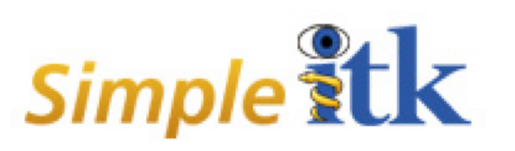

In [5]:
logo = sitk.ReadImage(fdata("SimpleITK.jpg"))

# GetArrayViewFromImage returns an immutable numpy array view to the data.
plt.imshow(sitk.GetArrayViewFromImage(logo))
plt.axis("off")

## Basic Image Attributes (Meta-Data)

You can change the image origin, spacing and direction. Making such changes to an image already containing data should be done cautiously. 

In [10]:
selected_image = image_3D
print("Before modification:")
print("origin: " + str(selected_image.GetOrigin()))
print("size: " + str(selected_image.GetSize()))
print("spacing: " + str(selected_image.GetSpacing()))
print("direction: " + str(selected_image.GetDirection()))
print("pixel type: " + str(selected_image.GetPixelIDTypeAsString()))
print(
    "number of pixel components: " + str(selected_image.GetNumberOfComponentsPerPixel())
)

selected_image.SetOrigin((78.0, 76.0, 77.0))
selected_image.SetSpacing([0.5, 0.5, 3.0])

print("\nAfter modification:")
print("origin: " + str(selected_image.GetOrigin()))
print("spacing: " + str(selected_image.GetSpacing()))
print("size: " + str(selected_image.GetSize()))

Before modification:
origin: (0.0, 0.0, 0.0)
size: (256, 128, 64)
spacing: (1.0, 1.0, 1.0)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 16-bit signed integer
number of pixel components: 1

After modification:
origin: (78.0, 76.0, 77.0)
spacing: (0.5, 0.5, 3.0)
size: (256, 128, 64)


what does this mean? this means, if you just set a net spacing, the overall image will not be influenced, instead, it just overwrites the spacing info into whatever you set. 
The proper way to do this is to __resample__ image based on the spacing.

Check [link](https://discourse.itk.org/t/resample-volume-to-specific-voxel-spacing-simpleitk/3531)

In [9]:
## let's load a real CT
CT_path = r"C:\Users\p70089067\Desktop\preop.nrrd"
assert os.path.exists(CT_path)
CT_volume = sitk.ReadImage(CT_path)
selected_image = CT_volume
print("Before modification:")
print("origin: " + str(selected_image.GetOrigin()))
print("size: " + str(selected_image.GetSize()))
print("spacing: " + str(selected_image.GetSpacing()))
print("direction: " + str(selected_image.GetDirection()))
print("pixel type: " + str(selected_image.GetPixelIDTypeAsString()))
print(
    "number of pixel components: " + str(selected_image.GetNumberOfComponentsPerPixel())
)

Before modification:
origin: (-100.8046875, -309.8046874999999, 1354.8)
size: (512, 512, 198)
spacing: (0.390625, 0.390625, 0.30000000000000077)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1


## Accessing Pixels and Slicing

Either use the ``GetPixel`` and ``SetPixel`` functions or the Pythonic slicing operator. The access functions and image slicing operator are in [x,y,z] order.

1
1
2
2


(-0.5, 199.5, 52.5, -0.5)

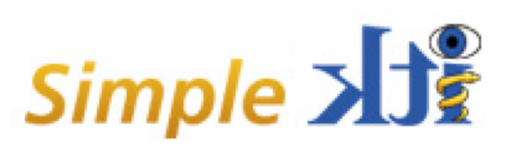

In [12]:
print(image_3D.GetPixel(0, 0, 0))
image_3D.SetPixel(0, 0, 0, 1)
print(image_3D.GetPixel(0, 0, 0))

# This can also be done using Pythonic notation.
print(image_3D[0, 0, 1])
image_3D[0, 0, 1] = 2
print(image_3D[0, 0, 1])

# We can also paste one image into the other using
# slicing. We'll first make a copy of the logo image, flip
# part of it and paste back in place.
logo_copy = sitk.Image(logo)
height = logo_copy.GetHeight()
logo_copy[115:190, 0:height] = logo_copy[190:115:-1, 0:height]
plt.imshow(sitk.GetArrayViewFromImage(logo_copy))
plt.axis("off")

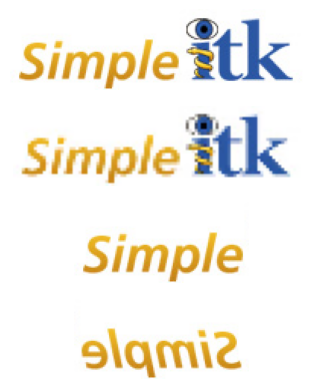

In [13]:
# Brute force sub-sampling
logo_subsampled = logo[::2, ::2]

# Get the sub-image containing the word Simple
simple = logo[0:115, :]

# Get the sub-image containing the word Simple and flip it
simple_flipped = logo[115:0:-1, :]

n = 4

plt.subplot(n, 1, 1)
plt.imshow(sitk.GetArrayViewFromImage(logo))
plt.axis("off")

plt.subplot(n, 1, 2)
plt.imshow(sitk.GetArrayViewFromImage(logo_subsampled))
plt.axis("off")

plt.subplot(n, 1, 3)
plt.imshow(sitk.GetArrayViewFromImage(simple))
plt.axis("off")

plt.subplot(n, 1, 4)
plt.imshow(sitk.GetArrayViewFromImage(simple_flipped))
plt.axis("off");

## Image operations

SimpleITK supports basic arithmetic operations between images while taking into account their meta-data. Images must physically overlap (pixel by pixel).

How close do physical attributes (meta-data values) need to be in order to be considered equivalent?

(-0.5, 127.5, 63.5, -0.5)

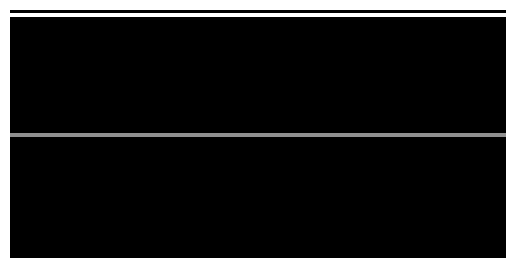

In [21]:
img_width = 128
img_height = 64
img1 = sitk.Image((img_width, img_height), sitk.sitkUInt8)
for i in range(img_width):
    img1[i, 1] = 5

img2 = sitk.Image(img1.GetSize(), sitk.sitkUInt8)
# img2.SetDirection([0,1,0.5,0.5])
img2.SetOrigin([0.000001, 0.000001])
#img2.SetOrigin([1, 1])
for i in range(img_width):
    img2[i, 1] = 120
    img2[i, img_height // 2] = 60

# Add the two images (upper line has a value of 125, and lower of 60)
img3 = img1 + img2

plt.imshow(sitk.GetArrayViewFromImage(img3), cmap=plt.cm.Greys_r)
plt.axis("off")

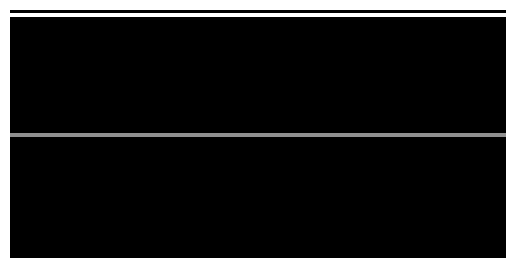

In [18]:
# operations can also be done in place
img1 += img2
plt.imshow(sitk.GetArrayViewFromImage(img1), cmap=plt.cm.Greys_r)
plt.axis("off");

Comparative operators (&gt;, &gt;=, &lt;, &lt;=, ==) are also supported, returning binary images.

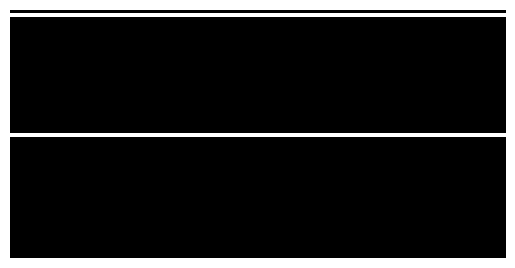

In [19]:
thresholded_image = img3 > 50
plt.imshow(sitk.GetArrayViewFromImage(thresholded_image), cmap=plt.cm.Greys_r)
plt.axis("off");

## SimpleITK2Numpy and Numpy2SimpleITK

__SimpleITK and numpy indexing access is in opposite order!__

SimpleITK: image[x,y,z]<br>
numpy: image_numpy_array[z,y,x]

### SimpleITK2Numpy

1. ```GetArrayFromImage()```: returns a copy of the image data. You can then freely modify the data as it has no effect on the original SimpleITK image.
2. ```GetArrayViewFromImage()```: returns a view on the image data which is useful for display in a memory efficient manner. You cannot modify the data and __the view will be invalid if the original SimpleITK image is deleted__.

### Numpy2SimpleITK
1. ```GetImageFromArray()```: returns a SimpleITK image with origin set to zero, spacing set to one for all dimensions, and the direction cosine matrix set to identity. Intensity data is copied from the numpy array. __In most cases you will need to set appropriate meta-data values.__ 


In [22]:
nda = sitk.GetArrayFromImage(image_3D)
print(image_3D.GetSize())
print(nda.shape)

nda = sitk.GetArrayFromImage(image_RGB)
print(image_RGB.GetSize())
print(nda.shape)

(256, 128, 64)
(64, 128, 256)
(128, 64)
(64, 128, 3)


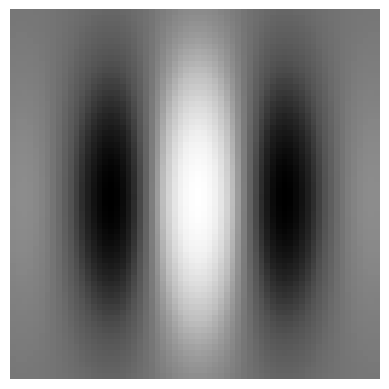

In [23]:
gabor_image = sitk.GaborSource(size=[64, 64], frequency=0.03)
# Getting a numpy array view on the image data doesn't copy the data
nda_view = sitk.GetArrayViewFromImage(gabor_image)
plt.imshow(nda_view, cmap=plt.cm.Greys_r)
plt.axis("off");

In [24]:
nda = np.zeros((10, 20, 3))

# if this is supposed to be a 3D gray scale image [x=3, y=20, z=10]
img = sitk.GetImageFromArray(nda)
print(img.GetSize())

# if this is supposed to be a 2D color image [x=20,y=10]
img = sitk.GetImageFromArray(nda, isVector=True)
print(img.GetSize())

(3, 20, 10)
(20, 10)


## Reading and Writing

SimpleITK can read and write images stored in a single file, or a set of files (e.g. DICOM series). The toolkit provides both an object oriented and a procedural interface. The primary difference being that the object oriented approach provides more control while the procedural interface is more convenient.

We look at DICOM images as an example illustrating this difference. Images stored in the DICOM format have a meta-data dictionary associated with them, which is populated with the DICOM tags. When a DICOM image series is read as a single image volume, the resulting image's meta-data dictionary is not populated since DICOM tags are specific to each of the files in the series. If you use the procedural method for reading the series then you do not have access to the set of meta-data dictionaries associated with each of the files. To obtain each dictionary you will have to access each of the files separately. On the other hand, if you use the object oriented interface, the set of dictionaries will be accessible from the ```ImageSeriesReader``` which you used to read the DICOM series. The meta-data dictionary for each file is available using the <a href="https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ImageSeriesReader.html#a337b19b6bc101f5571455afb46514b6d">HasMetaDataKey</a> and <a href="https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ImageSeriesReader.html#a19995f33b86c60e2ae4878cb4d8c30ee">GetMetaData</a> methods. 

We start with reading and writing an image using the procedural interface.

In [25]:
img = sitk.ReadImage(fdata("SimpleITK.jpg"))
sitk.WriteImage(img, os.path.join(OUTPUT_DIR, "SimpleITK.png"))

Fetching SimpleITK.jpg


Read an image in JPEG format and cast the pixel type according to user selection.

In [26]:
# Several pixel types, some make sense in this case (vector types) and some are just show
# that the user's choice will force the pixel type even when it doesn't make sense.
pixel_types = {
    "sitkVectorUInt8": sitk.sitkVectorUInt8,
    "sitkVectorUInt16": sitk.sitkVectorUInt16,
    "sitkVectorFloat64": sitk.sitkVectorFloat64,
}


def pixel_type_dropdown_callback(pixel_type, pixel_types_dict):
    # specify the file location and the pixel type we want
    img = sitk.ReadImage(fdata("SimpleITK.jpg"), pixel_types_dict[pixel_type])

    print(img.GetPixelIDTypeAsString())
    print(img[0, 0])
    plt.imshow(sitk.GetArrayViewFromImage(img))
    plt.axis("off")


interact(
    pixel_type_dropdown_callback,
    pixel_type=list(pixel_types.keys()),
    pixel_types_dict=fixed(pixel_types),
);

interactive(children=(Dropdown(description='pixel_type', options=('sitkVectorUInt8', 'sitkVectorUInt16', 'sitk…

Read a DICOM series and write it as a single mha file.

In [27]:
data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))
series_ID = "1.2.840.113619.2.290.3.3233817346.783.1399004564.515"

# Use the functional interface to read the image series.
original_image = sitk.ReadImage(
    sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series_ID)
)

# Write the image.
output_file_name_3D = os.path.join(OUTPUT_DIR, "3DImage.mha")
sitk.WriteImage(original_image, output_file_name_3D)

Fetching CIRS057A_MR_CT_DICOM/readme.txt


Select a specific DICOM series from a directory and only then load user selection.

In [28]:
data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))
# Global variable 'selected_series' is updated by the interact function
selected_series = ""
file_reader = sitk.ImageFileReader()


def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    global selected_series
    # Print some information about the series from the meta-data dictionary
    # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {
        "0010|0010": "Patient name: ",
        "0008|0060": "Modality: ",
        "0008|0021": "Series date: ",
        "0008|0080": "Institution name: ",
        "0008|1050": "Performing physician's name: ",
    }
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except:  # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load


# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
# Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(
            data_directory, series
        )

    interact(
        DICOM_series_dropdown_callback,
        series_to_load=list(series_IDs),
        series_dictionary=fixed(series_file_names),
    )
else:
    print("Data directory does not contain any DICOM series.")

Fetching CIRS057A_MR_CT_DICOM/readme.txt


interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.290.3.3233817346.783.1…

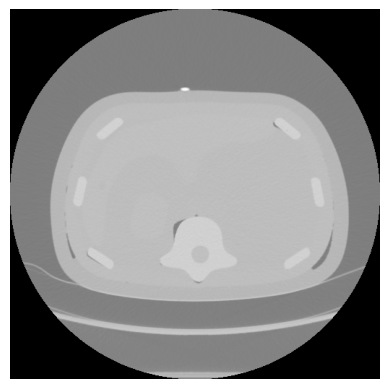

In [30]:
img = sitk.ReadImage(series_file_names[selected_series])
# Display the image slice from the middle of the stack, z axis
z = img.GetDepth() // 2
plt.imshow(sitk.GetArrayViewFromImage(img)[z, :, :], cmap=plt.cm.Greys_r)
plt.axis("off");

Write the volume as a series of JPEGs. The WriteImage function receives a volume and a list of images names and writes the volume according to the z axis. For a displayable result we need to rescale the image intensities (default is [0,255]) since the JPEG format requires a cast to the UInt8 pixel type.

In [31]:
sitk.WriteImage(
    sitk.Cast(sitk.RescaleIntensity(img), sitk.sitkUInt8),
    [
        os.path.join(OUTPUT_DIR, "slice{0:03d}.jpg".format(i))
        for i in range(img.GetSize()[2])
    ],
)

### Advanced Reading

SimpleITK relies on the registered ImageIO components to indicate whether they can read a file and then perform the reading. This is done automatically. You can select a specific ImageIO if multiple components can read the same format and you want to use a specific one.

Additionally, some of the ImageIO components support streaming. That is, they can read a portion of the image into memory. This is useful when working with large images.

In [39]:
file_reader = sitk.ImageFileReader()

# print the reader and see which ImageIO components are registered
print("\n", file_reader)

# select the JPEG ImageIO and read
file_reader.SetImageIO("JPEGImageIO")
file_reader.SetFileName(fdata("SimpleITK.jpg"))
logo = file_reader.Execute()

# when the ImageIO doesn't match the image type we get an exception
file_reader.SetImageIO("MetaImageIO")

file_reader.SetFileName(fdata("training_001_ct.mha"))
ct_head = file_reader.Execute()


 itk::simple::ImageFileReader
  FileName: ""
  ExtractSize: [ ]
  ExtractIndex: [ ]
  Image Information:
    PixelType: Unknown pixel id
    Dimension: 0
    NumberOfComponents: 0
    Direction: [ ]
    Origin: [ ]
    Spacing: [ ]
    Size: [ ]
  OutputPixelType: Unknown pixel id
  LoadPrivateTags: 0
  ImageIOName: 
  Registered ImageIO:
	BMPImageIO ( *.bmp, *.BMP )
	BioRadImageIO ( *.PIC, *.pic )
	Bruker2dseqImageIO
	GDCMImageIO ( *.dcm, *.DCM, *.dicom, *.DICOM )
	GE4ImageIO
	GE5ImageIO
	GiplImageIO
	HDF5ImageIO ( *.hdf, *.h4, *.hdf4, *.h5, *.hdf5, *.he4, *.he5, *.hd5 )
	JPEGImageIO ( *.jpg, *.JPG, *.jpeg, *.JPEG )
	JPEG2000ImageIO ( *.j2k, *.jp2, *.jpt )
	LSMImageIO ( *.lsm, *.LSM )
	MGHImageIO
	MINCImageIO ( *.mnc, *.MNC, *.mnc2, *.MNC2 )
	MRCImageIO ( *.mrc, *.rec )
	MetaImageIO ( *.mha, *.mhd )
	NiftiImageIO ( *.nia, *.nii, *.nii.gz, *.hdr, *.img, *.img.gz )
	NrrdImageIO ( *.nrrd, *.nhdr )
	PNGImageIO ( *.png, *.PNG )
	StimulateImageIO ( *.spr )
	TIFFImageIO ( *.tif, *.TIF, *.ti

In [40]:
# reset the reader's behavior so that it automatically selects the ImageIO
file_reader.SetImageIO("")
ct_head = file_reader.Execute()
image_viewer.Execute(ct_head)

If our region of interest is only in the central region of the image we can just read that region.

In [41]:
file_reader = sitk.ImageFileReader()
file_reader.SetFileName(fdata("training_001_ct.mha"))

# read the image information without reading the bulk data, compute ROI start and size and read it.
file_reader.ReadImageInformation()
start_index, extract_size = zip(
    *[(int(0.25 * sz), int(0.5 * sz)) for sz in file_reader.GetSize()]
)
file_reader.SetExtractIndex(start_index)
file_reader.SetExtractSize(extract_size)

image_viewer.Execute(file_reader.Execute())

Fetching training_001_ct.mha


## Resampling

<img src="figures/resampling.svg"/><br><br>

Resampling as the verb implies is the action of sampling an image, which itself is a sampling of an original continuous signal.

Generally speaking, resampling in SimpleITK involves four components:
1. Image - the image we resample, given in coordinate system $m$.
2. Resampling grid - a regular grid of points given in coordinate system $f$ which will be mapped to coordinate system $m$.
2. Transformation $T_f^m$ - maps points from coordinate system $f$ to coordinate system $m$, $^mp = T_f^m(^fp)$.
3. Interpolator - method for obtaining the intensity values at arbitrary points in coordinate system $m$ from the values of the points defined by the Image.


While SimpleITK provides a large number of interpolation methods, the two most commonly used are ```sitkLinear``` and ```sitkNearestNeighbor```. The former is used for most interpolation tasks, a compromise between accuracy and computational efficiency. The later is used to interpolate labeled images representing a segmentation, it is the only interpolation approach which will not introduce new labels into the result.

SimpleITK's procedural API provides three methods for performing resampling, with the difference being the way you specify the resampling grid:

1. ```Resample(const Image &image1, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```
2. ```Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```
3. ```Resample(const Image &image1, std::vector< uint32_t > size, Transform transform, InterpolatorEnum interpolator, std::vector< double > outputOrigin, std::vector< double > outputSpacing, std::vector< double > outputDirection, double defaultPixelValue, PixelIDValueEnum outputPixelType)```

In [45]:
def resample_display(image, euler2d_transform, tx, ty, theta):
    euler2d_transform.SetTranslation((tx, ty))
    euler2d_transform.SetAngle(theta)

    resampled_image = sitk.Resample(image, euler2d_transform, sitk.sitkLinear)# sitkNearestNeighbor)
    plt.imshow(sitk.GetArrayFromImage(resampled_image))
    plt.axis("off")
    plt.show()


euler2d = sitk.Euler2DTransform()
# Why do we set the center? because we want the image to rotate based on the center not the origin
euler2d.SetCenter(
    logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize()) / 2.0)
)
interact(
    resample_display,
    image=fixed(logo),
    euler2d_transform=fixed(euler2d),
    tx=(-128.0, 128.0, 2.5),
    ty=(-64.0, 64.0),
    theta=(-np.pi / 4.0, np.pi / 4.0),
);

interactive(children=(FloatSlider(value=-0.5, description='tx', max=128.0, min=-128.0, step=2.5), FloatSlider(…

### Common Errors

It is not uncommon to end up with an empty (all black) image after resampling. This is due to:
1. Using wrong settings for the resampling grid, not too common, but does happen.
2. Using the inverse of the transformation $T_f^m$. This is a relatively common error, which is readily addressed by invoking the transformations ```GetInverse``` method.

### Defining the Resampling Grid

In the example above we arbitrarily used the original image grid as the resampling grid. As a result, for many of the transformations the resulting image contained black pixels, pixels which were mapped outside the spatial domain of the original image and a partial view of the original image.

If we want the resulting image to contain all of the original image no matter the transformation, we will need to define the resampling grid using our knowledge of the original image's spatial domain and the **inverse** of the given transformation. 

Computing the bounds of the resampling grid when dealing with an affine transformation is straightforward. An affine transformation preserves convexity with extreme points mapped to extreme points. Thus we only need to apply the **inverse** transformation to the corners of the original image to obtain the bounds of the resampling grid.

Computing the bounds of the resampling grid when dealing with a BSplineTransform or DisplacementFieldTransform is more involved as we are not guaranteed that extreme points are mapped to extreme points. This requires that we apply the **inverse** transformation to all points in the original image to obtain the bounds of the resampling grid.  

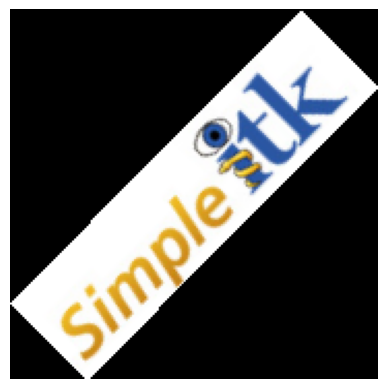

In [47]:
euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(
    logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize()) / 2.0)
)

tx = 64
ty = 32
euler2d.SetTranslation((tx, ty))
euler2d.SetAngle(0.79)

extreme_points = [
    logo.TransformIndexToPhysicalPoint((0, 0)),
    logo.TransformIndexToPhysicalPoint((logo.GetWidth(), 0)),
    logo.TransformIndexToPhysicalPoint((logo.GetWidth(), logo.GetHeight())),
    logo.TransformIndexToPhysicalPoint((0, logo.GetHeight())),
]
inv_euler2d = euler2d.GetInverse()

extreme_points_transformed = [inv_euler2d.TransformPoint(pnt) for pnt in extreme_points]
min_x = min(extreme_points_transformed)[0]
min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
max_x = max(extreme_points_transformed)[0]
max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]

# Use the original spacing (arbitrary decision).
output_spacing = logo.GetSpacing()
# Identity cosine matrix (arbitrary decision).
output_direction = [1.0, 0.0, 0.0, 1.0]
# Minimal x,y coordinates are the new origin.
output_origin = [min_x, min_y]
# Compute grid size based on the physical size and spacing.
output_size = [
    int((max_x - min_x) / output_spacing[0]),
    int((max_y - min_y) / output_spacing[1]),
]

resampled_image = sitk.Resample(
    logo,
    output_size,
    euler2d,
    sitk.sitkLinear,
    output_origin,
    output_spacing,
    output_direction,
)
plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
plt.axis("off")
plt.show()

In [52]:
resampled_image.GetSize(), logo.GetSize()

((178, 179), (200, 53))

Are you puzzled by the result? Is the output just a copy of the input? Add a rotation to the code above and see what happens (```euler2d.SetAngle(0.79)```).

<a href="03_trust_but_verify.ipynb"><h2 align=right>Next &raquo;</h2></a>